In [1]:
# Import Turing, Distributions, StatsBase, DataFrames and CSV, HypothesisTests and LinearAlgebra
using Turing, Distributions, StatsBase, DataFrames, CSV, HypothesisTests, LinearAlgebra

# Import MCMCChain, Plots and StatsPlots
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/HypothesisTests/MUGEl.ji for HypothesisTests [09f84164-cd44-5f33-b23f-e6b0d136a0d5]
└ @ Base loading.jl:1184
┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/eIa7P/src/Turing.jl:24


false

# Load dataset

In [2]:
# Load in the dataset downloaded from https://github.com/inertia7/timeSeries_sp500_R/blob/master/data/data_master_1.csv
#MIT License
df = CSV.read("../data/data_master_1.csv")
df[:sp_500]

252-element CSV.Column{Float64,Float64}:
  464.5475003
  479.0725098
  493.987503 
  507.725006 
  523.650009 
  538.8050078
  553.680008 
  560.649994 
  573.7274933
  582.0299835
  594.1499938
  612.3074953
  621.354996 
    ⋮        
 2028.592499 
 2050.415039 
 2082.582459 
 2081.859925 
 2099.35492  
 2089.485046 
 2086.920044 
 2014.084992 
 1945.722504 
 1996.757538 
 2074.259979 
 2056.099976 

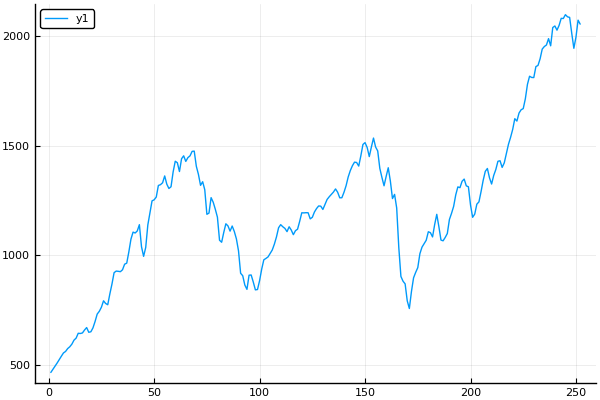

In [3]:
s = df.sp_500
pyplot()
plot(s)

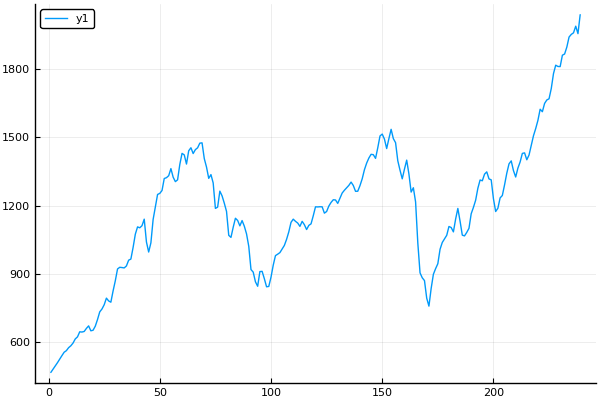

In [4]:
# Split into training and test sets. 
train_percentage = 0.95
s_train = s[1:floor(Int, train_percentage*length(s))]
N = length(s_train)

# Plot the training data
plot(s_train)

# Testing for stationarity and differencing the time series

In [5]:
ADFTest(s_train, Symbol("constant"), 5)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.007150541145066936

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.7835

Details:
    sample size in regression:          233
    number of lags:                     5
    ADF statistic:                      -0.9133697735711407
    Critical values at 1%, 5%, and 10%: [-3.45801 -2.87371 -2.57326]


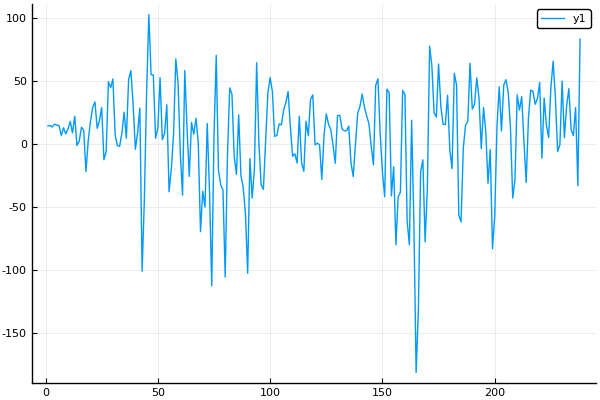

In [6]:
s_diff = diff(s_train)
plot(s_diff)

In [7]:
ADFTest(s_diff, Symbol("constant"), 5)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.5490223385232728

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-5

Details:
    sample size in regression:          232
    number of lags:                     5
    ADF statistic:                      -5.302400338677715
    Critical values at 1%, 5%, and 10%: [-3.45813 -2.87376 -2.57328]


# Analysing the ACF and PACF plots to determine AR and MA parameters

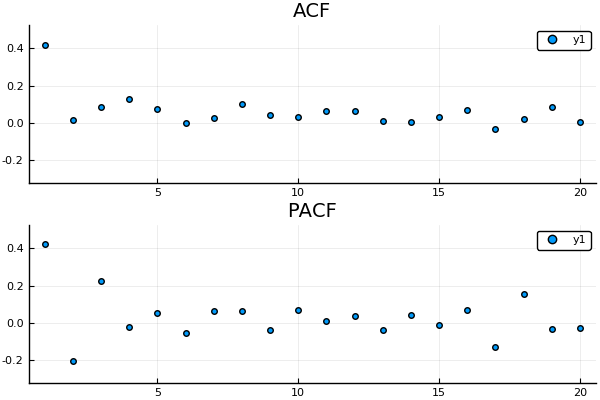

In [8]:
#Plot ACF and PACF plots
total_lags = 20
s1 = scatter(collect(1:total_lags), autocor(s_diff, collect(1:total_lags)), title = "ACF", ylim = [-0.3,0.5])
s2 = scatter(collect(1:total_lags), pacf(s_diff, collect(1:total_lags)), title = "PACF", ylim = [-0.3,0.5])
plot(s1, s2, layout = (2, 1))

# Defining the model and Sampling 

In [9]:
@model ARIMA110(x) = begin
    T = length(x)
    μ ~ Uniform(-10, 10)
    ϕ ~ Uniform(-1, 1)
    for t in 3:T
        val = μ +                      # Drift term.
              x[t-1] +                 # ARIMA(0,1,0) portion.
              ϕ * (x[t-1] - x[t-2]) # ARIMA(1,0,0) portion.
        x[t] ~ Normal(val, 1)
    end
end

ARIMA110 (generic function with 2 methods)

In [10]:
chain_ARIMA110 = sample(ARIMA110(s_train), NUTS(5000, 200, 0.6) )

┌ Info: Found initial step size
│   init_ϵ = 0.00625
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/eIa7P/src/inference/hmc.jl:364
┌ Info: Finished 200 adapation steps
│   adaptor = StanHMCAdaptor(n_adapts=200, pc=DiagPreconditioner, ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.6, state.ϵ=0.6914494740612657), init_buffer=75, term_buffer=50)
│   τ.integrator = Leapfrog(ϵ=0.691)
│   h.metric = DiagEuclideanMetric([0.000284431, 0.000103446])
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/sampler.jl:67
┌ Info: Finished 5000 sampling steps in 1.048775352 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([0.000284431, 0.000103446]))
│   τ = NUTS{Multinomial,Generalised}(integrator=Leapfrog(ϵ=0.691), max_depth=5), Δ_max=1000.0)
│   EBFMI(Hs) = 1682.1603000774248
│   mean(αs) = 0.6683132485417631
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/sampler.jl:77


Object of type Chains, with data of type 4800×12×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:4800
Thinning interval = 1
Chains            = 1
Samples per chain = 4800
internals         = eval_num, lp, acceptance_rate, hamiltonian_energy, is_accept, log_density, n_steps, numerical_error, step_size, tree_depth
parameters        = μ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse       │ ess     │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64    │ Any     │
├─────┼────────────┼──────────┼───────────┼─────────────┼────────────┼─────────┤
│ 1   │ μ          │ 3.91909  │ 0.0677754 │ 0.000978254 │ 0.00138877 │ 1813.61 │
│ 2   │ ϕ          │ 0.423982 │ 0.0016707 │ 2.41145e-5  │ 2.9357e-5  │ 2858.31 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%   │
│     │ Symbol     │ Float64  │ Float64  │ Float

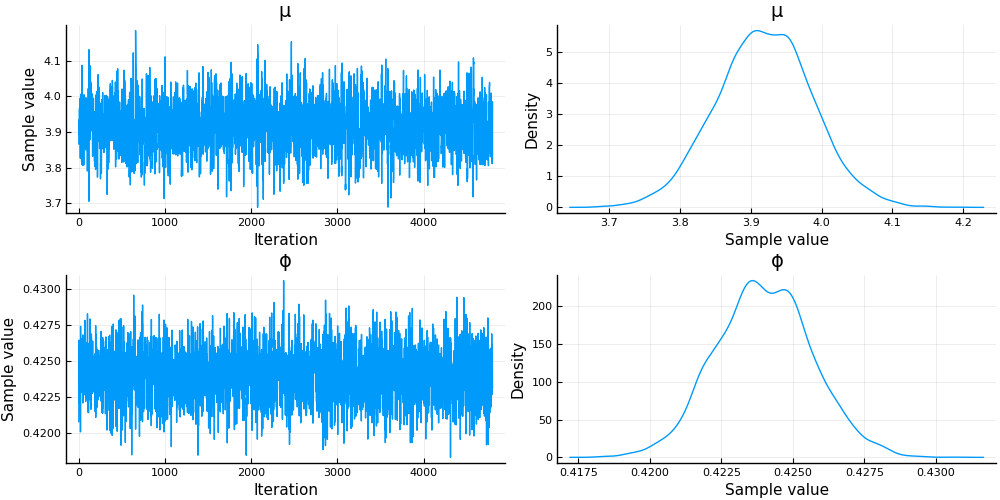

In [11]:
plot(chain_ARIMA110)

In [12]:
@model ARIMA011(x) = begin
    T = length(x)

    # Set up error vector.
    ϵ = Vector(undef, T)
    x_hat = Vector(undef, T)

    θ ~ Uniform(-5, 5)

    # Treat the first x_hat as a parameter to estimate.
    x_hat[1] ~ Normal(0, 1)
    ϵ[1] = x[1] - x_hat[1]

    for t in 2:T
        # Predicted value for x.
        x_hat[t] = x[t-1] - θ * ϵ[t-1]
        # Calculate observed error.
        ϵ[t] = x[t] - x_hat[t]
        # Observe likelihood.
        x[t] ~ Normal(x_hat[t], 1)
    end
end

ARIMA011 (generic function with 2 methods)

In [13]:
chain_ARIMA011 = sample(ARIMA011(s_train), NUTS(5000, 200, 0.6) )

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Info: Found initial step size
│   init_ϵ = 7.888609052210118e-32
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/eIa7P/src/inference/hmc.jl:364
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = tru

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36


Excessive output truncated after 524601 bytes.┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/hamiltonian.jl:36
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfiniteθ = true
│   isfiniter = false
│   isfiniteℓπ = false
│   isfiniteℓκ = false
└ @ AdvancedHMC /home/saumya/.julia/pac

Object of type Chains, with data of type 4800×12×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:4800
Thinning interval = 1
Chains            = 1
Samples per chain = 4800
internals         = eval_num, lp, acceptance_rate, hamiltonian_energy, is_accept, log_density, n_steps, numerical_error, step_size, tree_depth
parameters        = x_hat[1], θ

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std         │ naive_se    │ mcse    │ ess     │
│     │ Symbol     │ Float64 │ Float64     │ Float64     │ Float64 │ Any     │
├─────┼────────────┼─────────┼─────────────┼─────────────┼─────────┼─────────┤
│ 1   │ x_hat[1]   │ 1.73522 │ 1.55447e-15 │ 2.24369e-17 │ 0.0     │ 19.2771 │
│ 2   │ θ          │ 3.54197 │ 3.55308e-15 │ 5.12843e-17 │ 0.0     │ 19.2771 │

Quantiles

│ Row │ parameters │ 2.5%    │ 25.0%   │ 50.0%   │ 75.0%   │ 97.5%   │
│     │ Symbol     │ Float64 │ Float64 │ Float64 │ Floa

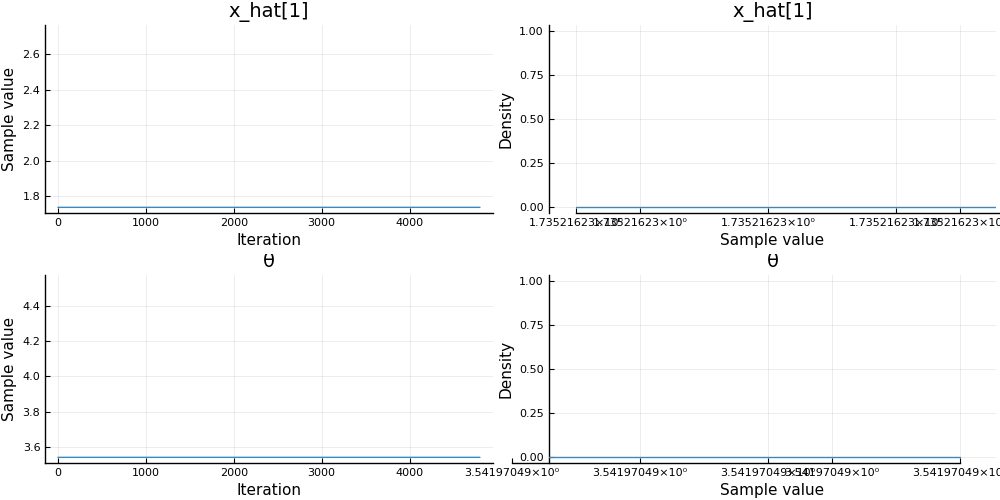

In [14]:
plot(chain_ARIMA011)

# Calculating AIC

In [15]:
# ARIMA 110 AIC calculation

function calculate_aic_ARIMA110(β::Float64, μ:: Float64, σ::Float64, s::Array{Float64, 1})
    T = length(s)
    ϵ = Vector(undef, T)
    s_pred = Vector(undef, T)
    
    s_pred[1], s_pred[2] = s[1], s[2]
    ϵ[1], ϵ[2] = 0.0, 0.0 
    for t in 3:T
        s_pred[t] = μ +                      
              s_pred[t-1] +                 
              β * (s_pred[t-1] - s_pred[t-2]) 
        ϵ[t] = s_pred[t] - s[t]
    end
    log_likelihood = (-(T - 1)/2)*2*π*σ^2 - (1/σ^2)*sum(ϵ.^2) - π*σ^2/(1 - β^2) - ((s[1] - μ/(1 - β))^2)/(2*σ^2/(1 - β^2))
    aic = -2*log_likelihood + 2
    return aic
end

# ARIMA 011 AIC calculation

function calculate_aic_ARIMA011(β::Float64, σ::Float64, s::Array{Float64, 1})
    T = length(s)

    ϵ = Vector(undef, T)
    s_pred = Vector(undef, T)

    s_pred[1] = s[1]
    ϵ[1] = 0.0
    for t in 2:T
        s_pred[t] = s[t-1] - β * ϵ[t-1]
        ϵ[t] = s[t] - s_pred[t]
    end
    log_likelihood = -(T/2)*log(2*π) - (T/2)*log(σ^2) + (1/2*σ^2)*sum(ϵ.^2)  
    aic = -2*log_likelihood + 1
    return aic
end

calculate_aic_ARIMA011 (generic function with 1 method)

In [16]:
calculate_aic_ARIMA011(mean(chain_ARIMA011[:θ].value), 1.0, s_train)

-9.861618132169624e262

In [17]:
calculate_aic_ARIMA110(mean(chain_ARIMA110[:ϕ].value), mean(chain_ARIMA110[:μ].value), 1.0, s_train)

6.222314801972279e7